This series aims to demystify embeddings and show you how to use them in your projects. This first blog post will teach you how to use and scale up open-source embedding models. We’ll look into the criteria for picking an existing model, current evaluation methods, and the state of the ecosystem. We’ll look into three exciting applications:


* Finding the most similar Quora or StackOverflow questions
* Given a huge dataset, find the most similar items
* Running search embedding models directly in the users’ browser (no server required)

You can either read the content here or execute it in Google Colab by clicking the badge at the top of the page. Let’s dive into embeddings!

## The TL;DR

You keep reading about "embeddings this" and "embeddings that", but you might still not know exactly what they are. You are not alone! Even if you have a vague idea of what embeddings are, you might use them through a black-box API without really understanding what’s going on under the hood. This is a problem because the current state of open-source embedding models is very strong - they are pretty easy to deploy, small (and hence cheap to host), and outperform many closed-source models.

An embedding represents information as a vector of numbers (think of it as a list!). For example, we can obtain the embedding of a word, a sentence, a document, an image, an audio file, etc. Given the sentence “Today is a sunny day”, we can obtain its embedding, which would be a vector of a specific size, such as 384 numbers (such vector could look like [0.32, 0.42, 0.15, …, 0.72]). What is interesting is that the **embeddings capture the semantic meaning of the information**. For example, embedding the sentence “Today is a sunny day” will be very similar to that of the sentence “The weather is nice today”. Even if the words are different, the meaning is similar, and the embeddings will reflect that.

:::callout

If you’re not sure what words such as “vector”, “semantic similarity”, the vector size, or “pretrained” mean, don’t worry! We’ll explain them in the following sections. Focus on the high-level understanding first.

:::

So, this vector captures the semantic meaning of the information, making it easier to compare to each other. For example, we can use embeddings to find similar questions in Quora or StackOverflow, search code, find similar images, etc. Let’s look into some code!

We’ll use Sentence Transformers, an open-source library that makes it easy to use pre-trained embedding models. In particular, ST allows us to turn sentences into embeddings quickly. Let’s run an example and then discuss how it works under the hood.

Let's begin by installing the library:

In [1]:
%%capture
!pip install sentence_transformers

The second step is to load an existing model. We'll start using [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). It's not the best open-source embedding model, but it's quite popular and very small (23 million parameters), which means we can get started with it very quickly.

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

Now that we loaded a model, let's use it to encode some sentences. We can use the `encode` method to obtain the embeddings of a list of sentences. Let's try it out!

In [3]:
from sentence_transformers import util

sentences = ["The weather today is beautiful", "It's raining!", "Dogs are awesome"]
embeddings = model.encode(sentences)
embeddings.shape

(3, 384)

all-MiniLM-L6-v2 creates embeddings of 384 values. We obtain three embeddings, one for each sentence. Think of `embeddings` as a "database" of embeddings. Given a new sentence, how can we find the most similar sentence? We can use the `util.pytorch_cos_sim` method to compute the cosine similarity (we'll talk more about it soon) between the new sentence embedding and all the embeddings in the database. The cosine similarity is a number between 0 and 1 that indicates how similar two embeddings are. A value of 1 means that the embeddings are identical, while 0 means that the embeddings are entirely different. Let’s try it out!

In [4]:
first_embedding = model.encode("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(first_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


What can we interpret of this? Although “today is a sunny day” and “the weather today is beautiful” don’t have the same words, the embeddings can capture some semantic meaning, so the cosine similarity is relatively high. On the other hand, “Dogs are awesome”, although true, has nothing to do with the weather or today; hence, the cosine similarity is very low.

To expand on this idea of similar embeddings, let’s look into how they could be used in a product. Imagine that U.S. Social Security would like to allow users to write Medicare-related questions in an input field. This topic is very sensitive, and we likely don’t want a model to hallucinate with something unrelated! Instead, we can leverage a database of questions (in this case, there’s an existing Medicare FAQ). The process is similar to the above"

1. We have a corpus (collection) of questions and answers.
2. We compute the embeddings of all the questions.
3. Given a new question, we compute its embedding.
4. We compute the cosine similarity between the new question embedding and all the embeddings in the database.
5. We return the most similar question (which is associated with the most similar embedding).

Steps 1 and 2 can be done offline (that is, we compute the embeddings only once and store them). The rest of the steps can be done at search time (each time a user asks a question). Let’s see what this would look like in code.

[![Representation of embeddings in two dimensions](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/embedding.png?raw=1)](https://huggingface.co/spaces/sentence-transformers/embeddings-semantic-search)

 Let’s first create our map of frequently asked questions.

In [5]:
# Data from https://faq.ssa.gov/en-US/topic/?id=CAT-01092

faq = {
    "How do I get a replacement Medicare card?": "If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.",
    "How do I sign up for Medicare?": "If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.",
    "What are Medicare late enrollment penalties?": "In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995",
    "Will my Medicare premiums be higher because of my higher income?": "Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.",
    "What is Medicare and who can get it?": "Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.",
}

Once again, we use the `encode` method to obtain the embeddings of all the questions.

In [6]:
corpus_embeddings = model.encode(list(faq.keys()))
print(corpus_embeddings.shape)

(5, 384)


Once a user asks a question, we obtain its embedding. We usually refer to this embedding as the query embedding.

In [7]:
user_question = "Do I need to pay more after a raise?"
query_embedding = model.encode(user_question)
query_embedding.shape

(384,)

We can now compute the similarity between the corpus embeddings and the query embedding. We could have a loop and use `util.pytorch.cos_sim` as we did before, but Sentence Transformers provides an even friendlier method called `semantic_search` that does all the work for us. It returns the top-k most similar embeddings  and their similarity score. Let's try it out!

In [8]:
similarities = util.semantic_search(query_embedding, corpus_embeddings, top_k=3)
similarities

[[{'corpus_id': 3, 'score': 0.4642062187194824},
  {'corpus_id': 4, 'score': 0.11628509312868118},
  {'corpus_id': 2, 'score': 0.09916296601295471}]]

Let’s now look at which questions and answers this corresponds to:

In [9]:
for i, result in enumerate(similarities[0]):
    corpus_id = result["corpus_id"]
    score = result["score"]
    print(f"Top {i+1} question (p={score}): {list(faq.keys())[corpus_id]}")
    print(f"Answer: {list(faq.values())[corpus_id]}")

Top 1 question (p=0.4642062187194824): Will my Medicare premiums be higher because of my higher income?
Answer: Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.
Top 2 question (p=0.11628509312868118): What is Medicare and who can get it?
Answer: Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.
Top 3 question (p=0.09916296601295471): What are Medicare late enrollment penalties?
Answer: In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find 

Great, so given the question "Do I need to pay more after a raise?", we know that the most similar question is "Will my Medicare premiums be higher because of my higher income?" and hence we can return the provided answer. In practice, you would likely have thousands to millions of embeddings, but this was a simple yet powerful example of how embeddings can be used to find similar questions.

Now that we better understand what embeddings are and how they can be used, let’s do a deeper dive into them!

## From word embeddings to sentence embeddings

### Word2Vec and GloVe

It’s time to take a step back and learn more about embeddings and why they are needed. Neural networks, such as BERT, are not able to process words directly; they need numbers. And the way to provide words is to represent them as vectors, also called word embeddings.

In the traditional setup, you define a vocabulary (which words are allowed), and then each word in this vocabulary has an assigned embedding. Words not in the vocabulary are mapped to a special token, usually called <UNK> (a standard placeholder for words not found during training). For example, let’s say we have a vocabulary of three words, and we assign each word a vector of size five. We could have the following embeddings:

| Word | Embedding |
| ---- | --------- |
| king    | [0.15, 0.2, 0.2, 0.3, 0.5] |
| queen   | [0.12, 0.1, 0.19, 0.3, 0.47] |
| potato    | [0.13, 0.4, 0.1, 0.15, 0.01] |
| `<UNK>`    | [0.01, 0.02, 0.01, 0.4, 0.11] |

The embedding I wrote above are numbers that I wrote somewhat randomly. In practice, **the embeddings are learned**. This is the main idea of methods such as [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) and [GloVe](https://nlp.stanford.edu/pubs/glove.pdf). They learn the embeddings of the words in a corpus in such a way that words that appear in similar contexts have similar embeddings. For example, the embeddings of "king" and "queen" are similar because they appear in similar contexts.

[![Word embeddings](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/embedding.png?raw=1)](https://huggingface.co/spaces/sentence-transformers/embeddings-semantic-search)

Some open-source libraries, such as Gensim and fastText, allow you to obtain pre-trained Word2Vec and GloVe embeddings quickly. In the good ol’ days of NLP (2013), people used these models to compute word embeddings, which were helpful as inputs to other models. For example, you can compute the word embeddings of each word in a sentence and then pass that as input to a sci-kit learn classifier to classify the sentiment of the sentence.

Glove and Word2Vec have fixed representations. Once they are trained, each word is assigned a fixed vector representation, regardless of their context (so “bank” in “river bank” and “savings bank” would have the same embedding). **Word2vec and GloVe will struggle with words that have multiple meanings.**

![The good ol' days of NLP](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/word2vec_meme.jpeg?raw=1)


:::callout

Understanding the details of word2vec and GloVe is unnecessary to understand the rest of the blog post and sentence embeddings, so I’ll skip them. I recommend reading this [chapter from the excellent interactive NLP course](https://lena-voita.github.io/nlp_course/word_embeddings.html) if you're interested.

As a TL;DR

* Word2Vec is trained by passing a very large corpus and training a shallow neural network to predict the surrounding words. Later alternatives predict the center word given the surrounding words.
* GloVe is trained by looking at the co-occurrence matrix of words (how often words appear together within a certain distance) and then using that matrix to obtain the embeddings.

Word2Vec and GloVe are trained with objectives that ensure that words appearing in similar contexts have similar embeddings.

:::

### Word Embeddings with Transformers

More recently, with the advent of transformers, we have new ways to compute embeddings. The embedding is also learned, but instead of training an embedding model and then another model for the specific task, transformers learn useful embeddings in the context of their task. For example, BERT, a popular transformer model, learns word embeddings in the context of masked language modeling (predicting which word to fill in the blank) and next sentence prediction (whether sentence B follows sentence A).

Transformers are state-of-the-art in many NLP tasks and can capture contextual information that word2vec and GloVe cannot capture, thanks to a mechanism called attention. Attention allows the model to weigh other words' importance and capture contextual information. For example, in the sentence “I went to the bank to deposit money”, the word “bank” is ambiguous. Is it a river bank or a savings bank? The model can use the word “deposit” to understand that it’s a savings bank. These are **contextualized embeddings** - their word embedding can differ based on their surrounding words.

Ok...we talked a lot about word embeddings; time to run some code. Let's use a pre-trained transformer model, [bert-base-uncased](https://huggingface.co/bert-base-uncased), and obtain some word embeddings. We'll use the `transformers` library for this. Let's begin by loading the model and its tokenizer

In [10]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

We haven’t talked about tokenization so far. Until now, we’ve assumed we split data into words. When using transformers, we divided text into tokens. For example, the word “banking” could be split into two tokens, “bank” and “ing”. The tokenizer is responsible for breaking the data into tokens, and the way it splits the data is model-specific and is a deterministic learning process, which means that the same word will always be split into the same tokens. Let’s see what this looks like in code:

In [11]:
text = "The king and the queen are happy."
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'the', 'king', 'and', 'the', 'queen', 'are', 'happy', '.', '[SEP]']

Alright, in this example, each word was a token! (this is not always the case, as we'll soon see). But we also see two things that might be unexpected: `[CLS]` and `[SEP]`. These are special tokens added to the sentence's beginning and end. These are used because BERT was trained with that format. One of BERT's training objectives is next-sentence prediction, which means that it was trained to predict whether two sentences are consecutive. The `[CLS]` token represents the entire sentence, and the `[SEP]` token separates sentences. This will be interesting later when we talk about sentence embeddings.

 Let's now obtain the embeddings of each token.

In [12]:
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output["last_hidden_state"].shape

torch.Size([1, 10, 768])

Great! BERT is giving us an embedding of 768 values for each token. Each of these tokens has semantic information - **they capture the meaning of the word in the context of the sentence**. Let's see if the embedding corresponding to the word "king" in this context is similar to the one in "queen".

In [13]:
king_embedding = output["last_hidden_state"][0][2]  # 2 is the position of king
queen_embedding = output["last_hidden_state"][0][5]  # 5 is the position of queen
print(f"Shape of embedding {king_embedding.shape}")
print(
    f"Similarity between king and queen embedding {util.pytorch_cos_sim(king_embedding, queen_embedding)[0][0]}"
)

Shape of embedding torch.Size([768])
Similarity between king and queen embedding 0.7920709848403931


Ok, it seems they are quite similar in this context! Let’s now look at the word “happy”.

In [14]:
happy_embedding = output.last_hidden_state[0][7]  # happy
util.pytorch_cos_sim(king_embedding, happy_embedding)

tensor([[0.5239]], grad_fn=<MmBackward0>)

This makes sense; the queen embedding is more similar to the king than the happy embedding.

Let's now look at how the same word can have different values depending on the context:

In [15]:
text = "The angry and unhappy king"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output["last_hidden_state"].shape

torch.Size([1, 7, 768])

In [16]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'the', 'angry', 'and', 'unhappy', 'king', '[SEP]']

In [17]:
king_embedding_2 = output["last_hidden_state"][0][5]
util.pytorch_cos_sim(king_embedding, king_embedding_2)

tensor([[0.5740]], grad_fn=<MmBackward0>)

Wow! Although both embeddings seem to correspond to the "king" embedding, they are pretty different in the vector space. What is going on? Remember that these are contextual embeddings. The context of the first sentence is quite positive, while the second sentence is quite negative. Hence, the embeddings are different.

Previously, we discussed how the tokenizer might split a word into multiple tokens. A valid question is how we would obtain the word embedding in such a case. Let’s look at an example with the long word “tokenization.”

In [18]:
tokenizer.tokenize("tokenization")

['token', '##ization']

The word "tokenization" was split into two tokens, but we care about the embedding of "tokenization"! What can we do? We can do a **pooling strategy** in which we obtain the embedding of each token and then average them to obtain the word embedding. Let's try it out!

As before, we get started by tokenizing the test and running the token IDs through the model.

In [19]:
text = "this is about tokenization"

encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)

Let's look at the tokenization of the sentence:

In [20]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'this', 'is', 'about', 'token', '##ization', '[SEP]']

So we want to pool the embeddings of the tokens 4 and 5 by averaging them. Let's first obtain the embeddings of the tokens.

In [21]:
word_token_indices = [4, 5]
word_embeddings = output["last_hidden_state"][0, word_token_indices]
word_embeddings.shape

torch.Size([2, 768])

And now let's average them using `torch.mean`.

In [22]:
import torch

torch.mean(word_embeddings, dim=0).shape

torch.Size([768])

Let's wrap all of it in a function so we can easily use it later.

In [23]:
def get_word_embedding(text, word):
    # Encode the text and do a forward pass through the model to get the hidden states
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():  # We don't need gradients for embedding extraction
        output = model(**encoded_input)

    # Find the indices for the word
    word_ids = tokenizer.encode(
        word, add_special_tokens=False
    )  # No special tokens anymore
    word_token_indices = [
        i
        for i, token_id in enumerate(encoded_input["input_ids"][0])
        if token_id in word_ids
    ]

    # Pool the embeddings for the word
    word_embeddings = output["last_hidden_state"][0, word_token_indices]
    return torch.mean(word_embeddings, dim=0)

**Example 1.** Similarity between king and queen embeddings in the context of both being angry.

In [24]:
util.pytorch_cos_sim(
    get_word_embedding("The king is angry", "king"),
    get_word_embedding("The queen is angry", "queen"),
)

tensor([[0.8564]])

**Example 2.** Similarity between king and queen embeddings in the context of the king being happy and the queen angry. Notice how they are less similar than in the previous example.

In [25]:
util.pytorch_cos_sim(
    get_word_embedding("The king is happy", "king"),
    get_word_embedding("The queen is angry", "queen"),
)

tensor([[0.8273]])

**Example 3**. Similarity between king embeddings in two very different contexts. Even if they are the same word, the different context of the word makes the embeddings very different.

In [26]:
# This is same as before
util.pytorch_cos_sim(
    get_word_embedding("The king and the queen are happy.", "king"),
    get_word_embedding("The angry and unhappy king", "king"),
)

tensor([[0.5740]])

**Example 4.** Similarity between a word that has two different meanings. The word "bank" is ambiguous, it can be a river bank or a savings bank. The embeddings are different depending on the context.

In [27]:
util.pytorch_cos_sim(
    get_word_embedding("The river bank", "bank"),
    get_word_embedding("The savings bank", "bank"),
)

tensor([[0.7587]])

I hope this gave an idea about what word embeddings are. Now that we understand word embeddings let’s look into sentence embeddings!

### Sentence Embeddings

Just as word embeddings are vector representations of words, sentence embeddings are vector representations of a sentence. We can also compute embeddings of paragraphs and documents! Let’s look into it.

There are three approaches we can take: `[CLS]` pooling, max pooling and mean pooling.

* Mean pooling means averaging all the word embeddings of the sentence.
* Max pooling means taking the maximum value of each dimension of the word embeddings.
* `[CLS]` pooling means using the embedding corresponding to the `[CLS]` token as the sentence embedding. Let's look deeper into this last one, which is the least intuitive.

#### [CLS] Pooling

As we saw before, BERT adds a special token `[CLS]` at the beginning of the sentence. This token is used to represent the entire sentence. For example, when someone wants to fine-tune a BERT model to perform text classification, a common approach is to add a linear layer on top of the `[CLS]` embedding. The idea is that the `[CLS]` token will capture the meaning of the entire sentence.

![The hidden state/embedding corresponding to the `CLS` token can be used to fine-tune a classification model.](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/classification.png?raw=1)

We can take the same approach and use the embedding of the [CLS] token as the sentence embedding. Let’s see how this works in code. We’ll use the same sentence as before.

In [28]:
encoded_input = tokenizer("This is an example sentence", return_tensors="pt")
model_output = model(**encoded_input)
sentence_embedding = model_output["last_hidden_state"][:, 0, :]
sentence_embedding.shape

torch.Size([1, 768])

Great! We obtained the model output's first embedding, corresponding to the [CLS] token. Let’s wrap this code into a function.

In [29]:
def cls_pooling(model_output):
    return model_output["last_hidden_state"][:, 0, :]


def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [30]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.9261]]) The weather today is beautiful
tensor([[0.8903]]) It's raining!
tensor([[0.9317]]) Dogs are awesome


Hmm...something looks off here 🤔 One would have expected this to work out of the box.

Well, it turns out BERT has an additional trick. As mentioned before, when BERT was trained, the CLS token was used to predict whether two sentences were consecutive. To do so, BERT processes the [CLS]-corresponding embedding and passes it through a linear layer and a tanh activation function (see [code here](https://github.com/huggingface/transformers/blob/95754b47a6d4fbdad3440a45762531e8c471c528/src/transformers/models/bert/modeling_bert.py#L652C7-L665)). The idea is that the linear layer and the tanh activation function will learn a better representation of the `[CLS]` token.  This is the `pooler` component of the BERT model and is used to obtain the `model_output.pooler_output`.

:::callout

This might sound confusing, so let’s repeat what’s happening here.

1. BERT outputs the embeddings of each token.
2. The first embedding corresponds to the `[CLS]` token.
3. The `[CLS]` token is processed through a linear layer and a tanh activation function to obtain the `pooler_output`.

During training, the pooler_output is used to predict whether two sentences are consecutive (one of the pre-training tasks of BERT). This makes processing the [CLS] token more meaningful than the raw [CLS] embedding.

:::

To show that there is no magic going on here, we can either pass the list of word embeddings to `model.pooler` or simply get the `pooler_output` from the model output. Let's try it out!

In [31]:
model.pooler(model_output["last_hidden_state"])[0][:10]

tensor([-0.9302, -0.4884, -0.4387,  0.8024,  0.3668, -0.3349,  0.9438,  0.3593,
        -0.3216, -1.0000], grad_fn=<SliceBackward0>)

In [32]:
model_output["pooler_output"][0][:10]

tensor([-0.9302, -0.4884, -0.4387,  0.8024,  0.3668, -0.3349,  0.9438,  0.3593,
        -0.3216, -1.0000], grad_fn=<SliceBackward0>)

Yay! As you can see, the first ten elements of the embedding are identical! Let’s now re-compute the distances using this new embedding technique:

In [33]:
def cls_pooling(model_output):
    return model.pooler(model_output["last_hidden_state"])  # we changed this


# This stays the same
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.9673]], grad_fn=<MmBackward0>) The weather today is beautiful
tensor([[0.9029]], grad_fn=<MmBackward0>) It's raining!
tensor([[0.8930]], grad_fn=<MmBackward0>) Dogs are awesome


Much, much better! We just obtained the closest sentences to "Today is a sunny day".

## Sentence Transformers

### Using the transformers library

This yields some decent results, but in practice, this was not much better than using Word2Vec or GloVe word embeddings and averaging them. The reason is that the [CLS] token is not trained to be a good sentence embedding. It’s trained to be a good sentence embedding for next-sentence prediction!

Introducing 🥁🥁🥁 Sentence Transformers! Sentence Sentence Transformers (also known as SBERT) have a special training technique focusing on yielding high-quality sentence embeddings. Just as in the TL;DR section of this blog post, let's use the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model.  In the beginning, we used the `sentence-transformers` library, which is a high-level wrapper library around `transformers`. Let's try to go the hard way first! The process is as follows:

1. We tokenize the input sentence.
2. We process the tokens through the model.
3. We calculate the mean of the token embeddings.
4. We normalize the embeddings to ensure the embedding vector has a unit length.

Just as before, we can load the model and the tokenizer, tokenize the sentence and pass it to the model

In [34]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
encoded_input = tokenizer("Today is a sunny day", return_tensors="pt")
model_output = model(**encoded_input)

What we’ve done until now is very similar to what we did before, except that we are using a different model. The next step is to do pooling. While previously we did [CLS] pooling, sentence transformers usually use mean or max pooling. Let’s try it out!

In [35]:
token_embeddings = model_output["last_hidden_state"]
token_embeddings.shape

torch.Size([1, 7, 384])

Note how, with this model, each embedding is smaller (384 values rather than 768). We can now compute the mean of the embeddings to obtain the sentence embedding.

In [36]:
mean_embedding = torch.mean(token_embeddings, dim=1)
mean_embedding.shape

torch.Size([1, 384])

The last step is to perform normalization. Normalization ensures that the embedding vector has a unit length, which means its length (or magnitude) is 1.

:::{.callout-note title="What is normalization?"}

To understand why we do normalization, revisiting some vector math is helpful. For a vector v with components (v1, v2, …, vn), it’s length is defined as

$$
\| \mathbf{v} \| = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

When normalizing a vector, we scale the values so that the vector length is 1. This is done by dividing each vector element by the vector’s magnitude.

$$
\mathbf{u} = \frac{\mathbf{v}}{\| \mathbf{v} \|}
$$

:::

This is particularly helpful when we want to compare vectors. For example, if we want to compute the cosine similarity between two vectors, we usually compare their direction rather than their magnitude. Normalizing the vectors ensures that each vector contributes equally to the similarity. We’ll talk more about embedding comparisons soon! Let’s try it out!

:::{.callout-note}

Actually, we are using cosine similarity to compute the similarity between embeddings. As we'll see later in the blog post, the magnitude of the embeddings is not relevant when computing the cosine similarity, but it's still a good think to normalize them in case we want to experiment with other ways to measure distances.

:::

In [37]:
import torch.nn.functional as F

normalized_embedding = F.normalize(mean_embedding)
normalized_embedding.shape

torch.Size([1, 384])

Let's wrap this in a function!

In [38]:
def mean_pooling(model_output):
    return torch.mean(model_output["last_hidden_state"], dim=1)


def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output)
    return F.normalize(sentence_embeddings)


get_sentence_embedding("Today is a sunny day")[0][:5]

tensor([-0.0163,  0.1041,  0.0974,  0.0742,  0.0375])

In practice, you'll likely be encoding batches of sentences, so we need to make some changes

* Modify the tokenization so we apply `truncation` (cutting the sentence if it's longer than the maximum length) and `padding` (adding `[PAD]` tokens to the end of the sentence).
* Modify the pooling so we take the attention mask into account. The attention mask is a vector of 0s and 1s that indicates which tokens are real and which are padding. We want to ignore the padding tokens when computing the mean!

In [39]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output["last_hidden_state"]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


# This now receives a list of sentences
def get_sentence_embedding(sentences):
    encoded_input = tokenizer(
        sentences, padding=True, truncation=True, return_tensors="pt"
    )
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    return F.normalize(sentence_embeddings)

In [40]:
query_embedding = get_sentence_embedding("Today is a sunny day")[0]
query_embedding[:5]

tensor([-0.0163,  0.1041,  0.0974,  0.0742,  0.0375])

We got the same result, great! Let's now repeat our search example from before.

In [41]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


Nice! Compared to the vanilla BERT [CLS]-pooled embeddings, the sentence transformer embeddings are more meaningful and have a larger difference between the unrelated vectors!

:::callout

When to use each pooling strategy? It depends on the task.

* `[CLS]` pooling is usually used when the transformer model has been fine-tuned on a specific downstream task that makes the `[CLS]` token very useful.
* Mean pooling is usually more effective on models that have not been fine-tuned on a downstream task. It ensures that all parts of the sentence are represented equally in the embedding and can work for long sentences where the influence of all tokens should be captured.
* Max pooling can be useful to capture the most important features in a sentence. This can be very useful if particular keywords are very informative, but it might miss the subtler context.

In practice, a pooling method will be stored with the model, and you won’t have to worry about it. If there’s no method specified, mean pooling is usually a good default.

:::

### Using the sentence-transformers library

This was relatively easy, but the `sentence-transformers` library makes it even easier for us to do all of this! Here is the same code as in the TL;DR section.

In [42]:
from sentence_transformers import SentenceTransformer

# We load the model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

query_embedding = model.encode("Today is a sunny day")
embeddings = model.encode(sentences)

for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


This is quite powerful! If you had to implement a feature to identify duplicate questions without using ML, you would likely have to implement a lexical search system (which looks at exact matches of the input question), a fuzzy search system (which looks at approximate matches of the input question), or a statistical search system (which looks at the frequency of words in the input question).

With embeddings, we can easily find similar questions without implementing any of these systems and having excellent results!

The following image is a good example of how embeddings can be used to find code that would answer a user’s question.

![Image of code search](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/search.png?raw=1)

### Embedding dimensions

As you saw before, the model we used, all-MiniLM-L6-v2, generates sentence embeddings of 384 values. This is a hyperparameter of the model and can be changed. The larger the embedding size, the more information the embedding can capture. However, larger embeddings are more expensive to compute and store.

The embeddings of popular open-source models go from 384 to 1024. The best current model, as of the time of writing, has embedding dimensions of 4096 values, but the model is much larger (7 billion parameters) compared to other models. In the closed-sourced world, Cohere has APIs that go from 384 to 4096 dimensions, OpenAI has embeddings of 1536, and so on. **Embedding dimension is a trade-off**. If you use very large embeddings, you will potentially get better results, but you will also have to pay more for hosting and inference. If you use vector databases, you will also have to pay more for storage.

### Sequence length

One of the limitations of transformer models is that they have a maximum sequence length. This means that they can only process a certain number of tokens. For example, BERT has a maximum context length of 512 tokens. This means that if you want to encode a sentence with more than 512 tokens, you will have to find ways to work around this limitation. For example, you could split the sentence into multiple sentences of 512 tokens and then average the embeddings. This is not ideal because the model will not be able to capture the context of the entire sentence.

This is not a problem for most use cases, but it can be a problem for long documents. For example, if you want to encode a 1000-word document, you will have to split it into multiple sentences of 512 tokens. This is not ideal because the model will not be able to capture the context of the entire document. Another approach can be to first generate a summary of the text and then encode the summary. This is a good approach if you want to encode long documents, but will require a good summarization model that might be too slow. Alternatively, you might know if a specific part of the document is good (such as abstracts, introductions, conclusions, etc.) and only encode that part if that's the most meaningful part for your task.

## Application 1. Finding most similar Quora duplicate

We're going to use the open-source [Quora dataset](https://huggingface.co/datasets/quora), which contains 400,000 pairs of questions from Quora. We will not train a model (yet!) and rather just use the embeddings to find similar questions given a new question. Let's get started!

Our first step will be to load the data - to do this, we'll use the `datasets` library.

In [43]:
%%capture
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
from datasets import load_dataset

dataset = load_dataset("quora")["train"]
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 404290
})

To take a quick look at the data within the `Dataset` object, we can convert it to a Pandas `DataFrame` and look at the first rows.

In [45]:
dataset.to_pandas().head()

,questions,is_duplicate
0,"{'id': [1, 2], 'text': ['What is the step by s...",False
1,"{'id': [3, 4], 'text': ['What is the story of ...",False
2,"{'id': [5, 6], 'text': ['How can I increase th...",False
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",False
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",False


Ok, so each sample is a dictionary. We do not care about the `is_duplicate` column here. Our goal is to find if any question in this dataset is similar to a new question. Let's process the dataset so we only have a list of questions.

In [46]:
corpus_questions = []
for d in dataset:
    corpus_questions.append(d["questions"]["text"][0])
    corpus_questions.append(d["questions"]["text"][1])
corpus_questions = list(set(corpus_questions))  # Remove duplicates
len(corpus_questions)

537362

The next step is to embed all the questions. We'll use the `sentence-transformers` library for this. We'll use the [`quora-distilbert-multilingual` model](https://huggingface.co/sentence-transformers/quora-distilbert-multilingual), which is a model trained for 100 languages and is trained specifically for Quora-style questions. This is a larger model, and hence will be slightly slower. It will also generate larger embeddings of 768 values.

To get some quick results without having to wait five minutes for the model to process all the questions, we'll only process the first 100000 questions. In practice, you would process all the questions or shuffle the questions and process a random subset of them when experimenting.

In [47]:
model = SentenceTransformer("quora-distilbert-multilingual")
questions_to_embed = 100000
corpus_embeddings = model.encode(
    corpus_questions[:questions_to_embed],
    show_progress_bar=True,
    convert_to_tensor=True,
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/447 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [48]:
corpus_embeddings.shape

torch.Size([100000, 768])

We just obtained 100,000 embddings in 20 seconds, even when this Sentence Transformer model is not tiny and I'm running this on my GPU-Poor computer. Unlike generative models, which are autoregressive and usually much slower, BERT-based models are super fast!

Let's now write a function that searches the corpus for the most similar question.

In [49]:
import time


def search(query):
    start_time = time.time()
    query_embedding = model.encode(query, convert_to_tensor=True)
    results = util.semantic_search(query_embedding, corpus_embeddings)
    end_time = time.time()

    print("Results (after {:.3f} seconds):".format(end_time - start_time))
    # We look at top 5 results
    for result in results[0][:5]:
        print(
            "{:.3f}\t{}".format(result["score"], corpus_questions[result["corpus_id"]])
        )

In [50]:
search("How can I learn Python online?")

Results (after 0.013 seconds):
0.988	How and from where can I learn Python language via video tutorials online?
0.979	Which are the best resources to learn Python?
0.975	What is the best source to learn Python?
0.975	How do you learn Python the hard way?
0.974	How do I learn Python in 5 days?


Let's try in Spanish!

In [51]:
search("Como puedo aprender Python online?")

Results (after 0.013 seconds):
0.988	How and from where can I learn Python language via video tutorials online?
0.978	Which are the best resources to learn Python?
0.976	What are some good resources to learn web scraping with Python?
0.974	What is the best source to learn Python?
0.974	How do you learn Python the hard way?


It seems to be working quite well! Note that although our model can process queries in other languages, such as Spanish in the example above, the embeddings were generated for English questions. This means that the model will not be able to find similar questions in other languages.

## Distance between embeddings

### Cosine similarity

Until now we've been computing the cosine similarity between embeddings. This is a number between 0 and 1 that indicates how similar two embeddings are. A value of 1 means that the embeddings are identical, while 0 means that the embeddings are entirely different. So far we've used it as a black-box, so let's look into it a bit more.

The cosine similarity allows us to compare how similar two vectors are regardless of their magnitude. For example, if we have two vectors, [1, 2, 3] and [2, 4, 6], they are very similar in terms of direction, but their magnitude is different. The cosine similarity will be close to 1, indicating that they are very similar.


In [52]:
a = torch.FloatTensor([1, 2, 3])
b = torch.FloatTensor([2, 3, 4])
util.cos_sim(a, b)

tensor([[0.9926]])

Let's plot both vectors. As you can see, they are very similar in terms of direction, but their magnitude is different.

In [53]:
a

tensor([1., 2., 3.])

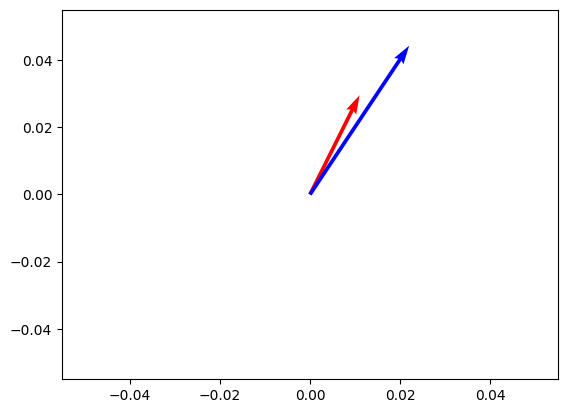

In [54]:
import matplotlib.pyplot as plt
import numpy as np

V = np.array([a.tolist(), b.tolist()])
origin = np.array([[0, 0], [0, 0]])  # origin point

plt.quiver(*origin, V[:, 0], V[:, 1], color=["r", "b", "g"], scale=10)
plt.show()

Let's dive into its math. Cosine similarity is defined as the dot product of the vectors divided by the product of their magnitudes:

$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

We already discussed magnitudes at the beginning of the blog post. We need to compute the square root of the sum of the squares of a vector component

$$
\|\mathbf{A}\| = \sqrt{1^2 + 2^2 + 3^2} = \sqrt{14}
$$

$$
\|\mathbf{B}\| = \sqrt{2^2 + 3^2 + 4^2} = \sqrt{29}
$$

We also need to compute the dot product of the vectors. The dot product is defined as the sum of the products of the corresponding vector components

$$
\mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i
$$

In this case, the dot product for A and B would look as follows

$$
\mathbf{A} \cdot \mathbf{B} = 1 \times 2 + 2 \times 3 + 3 \times 4 = 2 + 6 + 12 = 20
$$

Finally, we can compute the cosine similarity by doing

$$
\text{cosine similarity}(\mathbf{A}, \mathbf{B}) = \frac{20}{\sqrt{14} \sqrt{29}} = 0.992583
$$

which matches our result above.

:::{.callout-note}

Can you think of two vectors with cosine similarity of 1? Think of vectors with same direction but different magnitude.

:::

### Dot product

Cosine similarity does not take magnitude into account, but there might be use cases where the magnitude is meaningful. In those cases, **dot product** is a better metric. This means that longer or more verbose sentences with similar content could have a higher similarity score than shorter sentences with similar content due to their magnitude.

The dot product is defined as the sum of the products of the corresponding vector components (it's what we did before!)

$$
\mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^{n} A_i B_i
$$

If you look at the cosine similarity formula, if you assume the vectors are normalized (that is, their magnitude is 1), the cosine similarity is equivalent to the dot product. This means that the cosine similarity is a normalized dot product.

Let's create a new vector, [4, 6, 8]. This vector has the same direction as [2, 3, 4], but it's twice as long. Let's compute the dot product of [1, 2, 3] with [2, 3, 4] and [4, 6, 8].

In [55]:
c = torch.FloatTensor([4, 6, 8])

print(f"Cosine Similarity between a and b: {util.cos_sim(a, b)}")
print(f"Cosine Similarity between a and c: {util.cos_sim(a, c)}")

print(f"Dot product between a and b: {torch.dot(a, b)}")
print(f"Dot product between a and c: {torch.dot(a, c)}")

Cosine Similarity between a and b: tensor([[0.9926]])
Cosine Similarity between a and c: tensor([[0.9926]])
Dot product between a and b: 20.0
Dot product between a and c: 40.0


This makes sense! As b and c have the same angle, the cosine similarity is the same between a and b and a and c. However, the dot product is higher for a and c because c is longer than b.

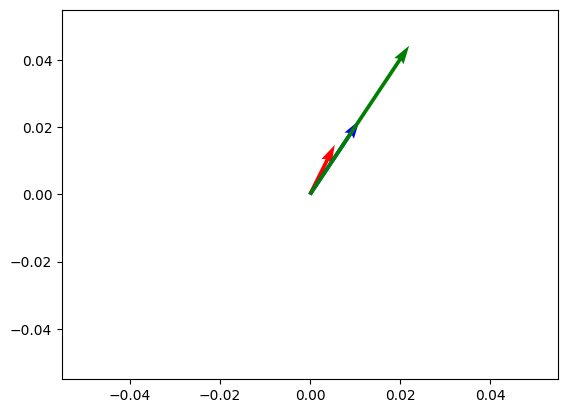

In [56]:
V = np.array([a.tolist(), b.tolist(), c.tolist()])
origin = np.array([[0, 0, 0], [0, 0, 0]])  # origin point

plt.quiver(*origin, V[:, 0], V[:, 1], color=["r", "b", "g"], scale=20)
plt.show()

### Euclidean Distance

The Euclidean Distance is the distance between two vectors by measuring a straight line between them. Just as the dot product, the Euclidean distance takes magnitude into account. I won't dive too much into interpreting both metrics, but the main idea is that the Dot Product measures how much one vector extends into the direction of another vector, while the Euclidean Distance measures the straight-line distance between two vectors. It is defined as the square root of the sum of the squared differences between the vector components. It's defined as

$$
\text{Euclidean Distance}(\mathbf{A}, \mathbf{B}) = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}
$$

In practice, you can use the Squared Euclidean (L2-Squared)

$$
\text{Squared Euclidean}(\mathbf{A}, \mathbf{B}) = \sum_{i=1}^{n} (A_i - B_i)^2
$$

### Picking a score function

We just learned about dot-product, cosine similarity, and euclidean distance. When to use which?

It depends on the model! Some models will be trained in a way that they produce normalized embeddings. In this case, dot-product, cosine similarity and euclidean distance will all produce the same results.

Other models are not trained in a way that they produce normalized embeddings - they are tuned for dot-product. In this case, dot-product will be the best function to find the closest items in a vector space. Even then, if the magnitude is not important, we can normalize as we did in the previous sections. **You can use different distance functions depending on your use case**. Models with normalized embeddings will prefer shorter sentences, while models with non-normalized embeddings will prefer longer sentences. This is because the magnitude of the embeddings will be larger for longer sentences.

| Distance function | Values | When to use |
| ----------------- | ------ | ----------- |
| Cosine similarity | [-1, 1] | When the magnitude is not important |
| Dot product       | [-inf, inf] | When the magnitude is important |
| Euclidean distance | [0, inf] | When the magnitude is important |

To recap:

* **Cosine similarity** focuses on the angle between vectors. It's a normalized dot product.
* **Dot product** focused on both magnitude and angle.
* **Euclidean distance** measures spatial distance between vectors.

There are other distance functions, such as Manhattan distance, but these are common ones and useful for our use cases!

## Scaling Up

Until now we've been working with just a couple of sentences. In practice, you might have to deal with millions of embeddings, and we cannot always compute the distance to all of them (this is called brute-force search).

One approach is to use an approximate nearest neighbor algorithm. These algorithms partition the data into buckets of similar embeddings. This allows us to quickly find the closest embeddings without having to compute the distance to all of them. This is not exact, as some vectors with high similarity might still be missed. There are different libraries you can use to do this, such as Spotify's [Annoy](https://github.com/spotify/annoy) and Facebook's [Faiss](https://github.com/facebookresearch/faiss). Vector databases such as Pinecone and Weaviate also use nearest neighbor techniques to be able to search millions of objects in milliseconds.

For now, let's look at an interesting application where the scaling issues become more apparent.

### Application 2. Paraphrase Mining

Until now, with semantic search, we've been looking for the sentence most similar to a query sentence. In **paraphrase mining**, the goal is to find texts with similar meaning in a very large corpus. Let's take our Quora dataset and see if we can find similar questions.

In [57]:
questions_to_embed = 10
short_corpus_questions = corpus_questions[:questions_to_embed]
short_corpus_questions

['',
 'Can I dye my hair twice in the same day going darker?',
 'Is there any kind of speaker that can play a USB flash drive?',
 'What is the best written article you have ever read?',
 "What's the difference between IT and COE at NSIT and DTU?",
 'Is pieing without consent legal?',
 "Do you feel it is Facebook's fault that people do not research information for themselves and think that fake news is real?",
 'When should I charge my iPhone 7 Plus?',
 'Why do some amino acids have more than one codon for their recognition?',
 'Which is the worst NYC borough?']

In [58]:
model = SentenceTransformer("quora-distilbert-multilingual")
embeddings = model.encode(short_corpus_questions, convert_to_tensor=True)

# Compute distance btween all embeddings
start_time = time.time()
distances = util.pytorch_cos_sim(embeddings, embeddings)
end_time = time.time()

print("Results (after {:.3f} seconds):".format(end_time - start_time))
distances

Results (after 0.000 seconds):


tensor([[1.0000, 0.7043, 0.6797, 0.7165, 0.7197, 0.7057, 0.7071, 0.7047, 0.7009,
         0.6645],
        [0.7043, 1.0000, 0.7279, 0.7031, 0.7568, 0.7737, 0.7469, 0.7460, 0.7722,
         0.7182],
        [0.6797, 0.7279, 1.0000, 0.6186, 0.7404, 0.7600, 0.7549, 0.7599, 0.7166,
         0.6794],
        [0.7165, 0.7031, 0.6186, 1.0000, 0.6414, 0.6536, 0.7284, 0.6341, 0.7232,
         0.6825],
        [0.7197, 0.7568, 0.7404, 0.6414, 1.0000, 0.7664, 0.7656, 0.7218, 0.7725,
         0.7437],
        [0.7057, 0.7737, 0.7600, 0.6536, 0.7664, 1.0000, 0.7872, 0.7934, 0.7428,
         0.7211],
        [0.7071, 0.7469, 0.7549, 0.7284, 0.7656, 0.7872, 1.0000, 0.7874, 0.7675,
         0.7381],
        [0.7047, 0.7460, 0.7599, 0.6341, 0.7218, 0.7934, 0.7874, 1.0000, 0.7028,
         0.7187],
        [0.7009, 0.7722, 0.7166, 0.7232, 0.7725, 0.7428, 0.7675, 0.7028, 1.0000,
         0.6626],
        [0.6645, 0.7182, 0.6794, 0.6825, 0.7437, 0.7211, 0.7381, 0.7187, 0.6626,
         1.0000]], device='c

Awesome! We just computed the distances of 10 embeddings vs 10 embeddings. It was quite fast. Let's try now with 1000 queries.

In [59]:
def compute_embeddings_slow(questions, n=10):
    embeddings = model.encode(
        questions[:n], show_progress_bar=True, convert_to_tensor=True
    )

    # Compute distance btween all embeddings
    start_time = time.time()
    distances = util.pytorch_cos_sim(embeddings, embeddings)
    end_time = time.time()

    return distances, end_time - start_time


_, s = compute_embeddings_slow(corpus_questions, 20000)
print("Results (after {:.3f} seconds):".format(s))

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Results (after 0.002 seconds):


Ok, that's still fast! Let's look at some other values

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/626 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (seconds)')

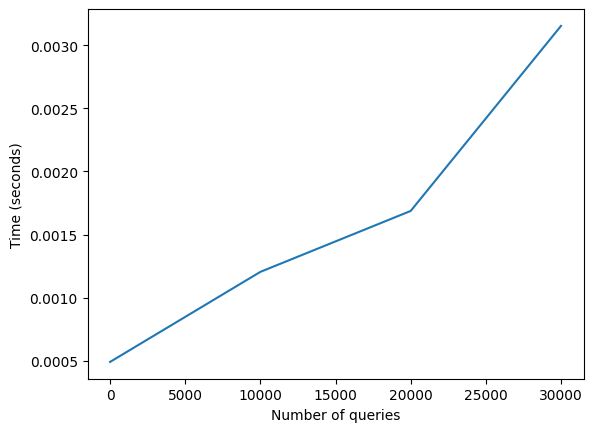

In [60]:
import matplotlib.pyplot as plt

n_queries = [1, 10001, 20001, 30001]  # If I keep going my computer explodes
times = []

for n in n_queries:
    _, s = compute_embeddings_slow(corpus_questions, n)
    times.append(s)
    torch.cuda.empty_cache()  # Clear GPU cache

plt.plot(n_queries, times)
plt.xlabel("Number of queries")
plt.ylabel("Time (seconds)")

The algorithm above has a quadratic runtime, so it won't scale up well if we keep increasing the number of queries. For larger collections, we can use the [paraphrase mining technique](https://www.sbert.net/examples/applications/paraphrase-mining/README.html), which is more complex and efficient.

In [61]:
start_time = time.time()
paraphrases = util.paraphrase_mining(
    model, corpus_questions[:100000], show_progress_bar=True
)
end_time = time.time()

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [62]:
len(paraphrases)

250839

In [63]:
paraphrases[:3]

[[1.0000007152557373, 33521, 42318],
 [1.0000004768371582, 44919, 52560],
 [0.9999999403953552, 12964, 16041]]

The first value is the score, the second is the index of a corpus question, and the third is another index to a corpus question. The score indicates how similar the two questions are.

Nice! We just
1. Computed the embeddings of 100,000 questions
2. Obtained the most similar sentences, and
3. Sorted them

All of this in 20 seconds! Let's look at the 5 matches with the highest similariy

In [64]:
for score, i, j in paraphrases[:5]:
    print("{:.3f}\t{} and {}".format(score, corpus_questions[i], corpus_questions[j]))

1.000	When should I use "has been", "have been" and "had been"? and When should I use "has been","have been" and "had been"?
1.000	I earn INR 30k/month. After paying rent I save around 10k. How can I save and invest so that after 10years I get a monthly interest of around 6k? and I earn INR 30k/month.After paying rent I save around 10k. How can I save and invest so that after 10years I get a monthly interest of around 6k?
1.000	 What is the most beautiful moment in your life? and What is the most beautiful moment in your life?
1.000	How can I solve physics numericals easily ? and How can I solve physics numericals easily?
1.000	I am going to attempt CPT in June 2016. Is the new syllabus applicable to me? and I am going to attempt CPT in June 2016 . Is the new syllabus applicable to me?


How does this method work? The corpus is divided into smaller chunks, which allows us to manage the memory and compute usage. There are two ways in which the chunking happens:

* **Query Chunk Size:** Determines how many sentences are considered as potential paraphrases. This is the number of sentences that are compared to the query sentence and controlled with `query_chunk_size` (5000 by default).
* **Corpus Chunk Size:** Determines how many chunks of the corpus are being compared simultaneously. This is controlled with `corpus_chunk_size` (100000 by default).

For example, with the default parameters, the algorithm processes 5000 sentences at a time, comparing each of these against chunks of 100000 sentences from the rest of the corpus. The algorithm is focused on getting the **top matches** - using `top_k`, for each sentence in a query chunk, the algorithm just selects the top k matches from the corpus chunk. This means that the algorithm will not find all the matches, but it will find the top matches. This is a good trade-off as we usually don't need all the matches, but just the top ones.

Both parameters make the process more efficient as it's computationally easier to handle smaller subsets of the data. It also helps use less memory as we don't have to load the entire corpus into memory to compute the similarity. Finding the right values for these parameters is a trade-off between speed and accuracy. The larger the values, the more accurate the results, but the slower the algorithm.

:::{.callout-note}

You can use `max_pairs` to limit the number of pairs returned.

:::

Here is some pseudocode of the algorithm:

```python
# Initialize an empty list to store the results
results = []

for query_chunk in query_chunks:
    for corpus_chunk in corpus_chunks:
        # Compute the similarity between the query chunk and the corpus chunk
        similarity = compute_similarity(query_chunk, corpus_chunk)
        # Get the top k matches in the other chunk
        top_k_matches = similarity.top_k(top_k)
        # Add the top k matches to the results
        results.add(top_k_matches)
```

## Selecting and evaluating models

You should have a pretty good understanding of sentence embeddings and what we can do with them. Today, we used two different models, `all-MiniLM-L6-v2` and `quora-distilbert-multilingual`. How do we know which one to use? How do we know if a model is good or not?

The first step is to know where to discover sentence embedding models. If you're using open-source ones, the Hugging Face Hub allows you to [filter for them](https://huggingface.co/models?library=sentence-transformers). The community has shared over 4000 models! Although looking at the trending models on Hugging Face is a good indicator (e.g., I can see the Microsoft Multilingual 5 Large model, a decent one), we need more information to pick a model.

[MTEB](https://huggingface.co/spaces/mteb/leaderboard) has us covered. This leaderboard contains multiple evaluation datasets for various tasks. Let's quickly look at some criteria we're interested in when picking a model.

* **Sequence length.** As discussed before, you might need to encode longer sequences depending on the expected user inputs. For example, if you're encoding long documents, you might need to use a model with a larger sequence length. Another alternative is to split the document into multiple sentences and encode each sentence separately.
* **Language.** The leaderboard contains mostly English or multilingual models, but you can also find models for other languages such as Chinese, Polish, Danish, Swedish, German, etc.
* **Embedding dimension.** As discussed before, the larger the embedding dimension, the more information the embedding can capture. However, larger embeddings are more expensive to compute and store.
* **Average metrics across tasks.** The leaderboard contains multiple tasks, such as clustering, re-ranking, and retrieval. You can look at the average performance across all tasks to get a sense of how good the model is.
* **Task-specific metrics.** You can also look at the model's performance in specific tasks. For example, if you're interested in clustering, you can look at the model's performance in the clustering task.

Knowing the purpose of the model is also essential. Some models will be generalist models. Others, such as [Specter 2](https://huggingface.co/allenai/specter2), are focused on specific tasks, such as scientific papers. I won't dive too much into all the tasks in the leaderboard, but you can look at the [MTEB paper](https://arxiv.org/abs/2210.07316) for more information. Let me give a brief summary of MTEB.

[![MTEB tasks image from the paper](https://github.com/osanseviero/hackerllama/blob/main/nbs/blog/posts/sentence_embeddings/mteb.png?raw=1)](https://arxiv.org/abs/2210.07316)

MTEB provides a benchmark of 56 datasets across eight tasks and contains 112 languages. It's easily extensible to add your datasets and models to the leaderboard. Overall, it's a straightforward tool to find the suitable speed-accuracy trade-off for your use case.

Today's (Jan 7th, 2024) top model is a large model, E5-Mistral-7B-instruct, which is 14.22Gb in size and an average of 66.63 over the 56 datasets. One of the next best open-source models is BGE-Large-en-v1.5, which is just 1.34Gb and performs an average of 64.23. And the base model for BGE, which is even smaller (0.44Gb), has a quality of 63.55! As a comparison, text-embedding-ada-002, even if it provides larger embeddings of 1536 dimensions, performs with a quality of 60.99. That's number 23 in the MTEB benchmark! Cohere provides better embeddings, with a quality of 64.47 and embeddings of 1024 dimensions.

I recommend looking at this [Twitter thread from 2022](https://twitter.com/Nils_Reimers/status/1487014195568775173), in which OpenAI embeddings were compared against other embeddings. The results are quite interesting! The costs were many orders of magnitude higher, and the quality was considerably lower than smaller models.

**All of this said, don't overfixate on a single number. You should always look at the specific metrics of your task and the particular resource and speed requirements**

It's interesting to look at the different tasks covered in MTEB to understand potential sentence embedding applications better.

* **Bitext Mining.** This task involves finding the most similar sentences in two sets of sentences, each in a different language. It is essential for machine translation and cross-lingual search.
* **Classification.** In this application, a logistic regression classifier is trained using sentence embeddings for text classification tasks.
* **Clustering.** Here, a k-means model is trained on sentence embeddings to group similar sentences together, useful in unsupervised learning tasks.
* **Pair Classification.** This task entails predicting whether a pair of sentences are similar, such as determining if they are duplicates or paraphrases, aiding in paraphrase detection.
* **Re-ranking.** In this scenario, a list of reference texts is re-ranked based on their similarity to a query sentence, improving search and recommendation systems.
* **Retrieval.** This application involves embedding queries and associated documents to find the most similar documents to a given query, crucial in search-related tasks.
* **Semantic Similarity.** This task focuses on determining the similarity between a pair of sentences, outputting a continuous similarity score, useful in paraphrase detection and related tasks.
* **Summarization.** This involves scoring a set of summaries by computing the similarity between them and a reference (human-written) summary, important in summarization evaluation.

## Showcase Application: Real-time Embeddings in your browser

We won't do the hands-on for this one, but I wanted to show you a cool application of embeddings. Lee Butterman built a [cool app](https://leebutterman.com/wikipedia-search-by-vibes/) where users can search among millions of Wikipedia articles by using embeddings. **What is extra nice here is that this is offline: the embeddings are stored in the browser and the model is running directly in your browser as well - nothing is being sent to a server!** 🤯

Preparing the data

* We first pre-compute an embedding database. The author used a small yet effective model, all-minilm-l6-v2.
* The database of 6 million pages * 384 dimensions * 4 bytes per float = 9.2 GB. This is quite large to have users download that.
* The author used a technique called [product quantization](https://en.wikipedia.org/wiki/Vector_quantization) to reduce the size of the database.
* The data is then exported to a format called Arrow, which is very compact!

:::{.callout-note}

Do not worry too much about the specifics here. Our main goal is to understand the high-level idea of this project; so don't be scared if this is the first time you hear the word "quantization"!

:::

At inference time

* Lee used [transformers.js](https://github.com/xenova/transformers.js), a library that allows to run transformers models in the browser with JavaScript. This requires having quantized models. Here is an example

```js
const extractor = await pipeline('feature-extraction', 'Xenova/all-MiniLM-L6-v2');
const output = await extractor('This is a simple test.', { pooling: 'mean', normalize: true });
// Tensor {
//   type: 'float32',
//   data: Float32Array [0.09094982594251633, -0.014774246141314507, ...],
//   dims: [1, 384]
// }
```

* `transformers.js` downloads the all-MiniLM-L6-v2 model to the browser and is used to compute the embeddings in the browser.
* The distance is then computed using [pq.js](https://github.com/lsb/pq.js).

Read more about this project in [Lee's blog post](https://www.leebutterman.com/2023/06/01/offline-realtime-embedding-search.html).This is a great example of how embeddings can be used in the browser!

## The State of the Ecosystem

The ecosystem around embeddings is quite large.

### Building on top of embeddings:

* There are cool tools such as `top2vec` and `bertopic` designed for buildimg topic embeddings.
* `keybert` is a library that allows extracting keywords and keyphrases similar to a document using BERT embeddings.
* `setfit` is a library that allows doing efficient few-shot fine-tuning of Sentence Transformers to use them for text classification.

### Embedding databases

2023 has been the year of embedding databases. [LangChain Integrations Section](https://integrations.langchain.com/vectorstores) show 65 vector stores. From Weaviate, Pinecone, and Chroma to Redis, ElasticSearch, and Postgres. Embedding databases are specialized to accelerate similarity search on embeddings, usually using approximate search algorithms. The new wave of embedding database startups has lead to a big amount of money being invested in it. At the same time, classical existing database companies have integrated vector indexes into their products, such as Cassandra and MongoDB.

### Research

The research around embeddings is also quite active. If you follow the MTEB benchmark, it changes every few weeks. Some of the players in this are are Microsoft (E5 models), Cohere, BAAI (BGE), Alibaba (GTE), NLP Group of The University of Hong Kong (Instructor), and Jina, among many others.

## Conclusion

What a journey! We just went from 0 to 1 in sentence embeddings. We learned about what they are, how to compute them, how to compare them, and how to scale them. We also saw some cool applications of embeddings, such as semantic search and paraphrase mining. I hope this blog post gave you a good understanding of what sentence embeddings are and how to use them. This is the first part of a series. What's left to learn?

* The role of vector databases
* How to use embeddings for more complex ranking systems
* Topic modeling
* Multimodality
* How to train your own embedding models
* All about RAGs

There will be a time for each of those! For now, I suggest to take a break to check your knowledge. Don't hesitate to change the code and play with it! If you like this blog post, don't hesitate to [leave a GitHub Star](https://github.com/osanseviero/hackerllama) or share it!

## Knowledge Check

1. What make transformer models more useful than GloVe or Word2Vec for computing embeddings?
2. What is the role of the `[CLS]` token in BERT and how does it help for computing sentence embeddings?
3. What's the difference between `pooler_output` and the `[CLS]` token embedding?
4. What's the difference between `[CLS]` pooling, max pooling, and mean pooling?
5. What is the sequence length limitation of transformer models and how can we work around it?
6. When do we need to normalize the embeddings?
7. Which two vectors would give a cosine similarity of -1? What about 0?
8. Explain the different parameters of the `paraphrase_mining` function.
9. How would you choose the best model for your use case?

## Resources

Here are some useful resources:

* [Sentence Transformers](https://www.sbert.net/)
* [Hugging Face Hub](https://huggingface.co/models?library=sentence-transformers)
* [MTEB Leaderboard](https://huggingface.co/blog/mteb)
